# Exploratory Data Analysis (EDA) #

In [64]:
import numpy as np
import pandas as pd
import os

# Load the data from the .npy file
data_path = 'data/ai_ready'
file_name = '1_ready.npy'
full_path = os.path.join(data_path, file_name)
east_component_data = np.load(full_path)

# Define a window size and overlap (in number of samples)
freq = 25 #25 samples per second (For Sitkin Data)
window_size = 15 * 60 * 25  #15 minute long window
overlap = 500

# Sliding window function
def sliding_window(data, window_size, overlap):
    step = window_size - overlap
    windows = [data[i:i+window_size] for i in range(0, len(data)-window_size+1, step)]
    return windows

# Apply the sliding window function to the data
windows = sliding_window(east_component_data, window_size, overlap)

# Feature extraction: calculate mean, std, etc. for each window
features = []
for window in windows:
    mean = np.mean(window)
    std = np.std(window)
    max_val = np.max(window)
    min_val = np.min(window)
    features.append([mean, std, max_val, min_val])

# Convert the features list to a NumPy array
features = np.array(features)

# Print the shape of the features array to verify
print('Features shape:', features.shape, '\n')

# Print the first few rows of the features array
print('First 5 rows of features:')
print(features[:5], '\n')

# Print summary statistics for each feature
feature_names = ['Mean', 'Std', 'Max', 'Min']
for i, name in enumerate(feature_names):
    print(f'{name} - Mean: {np.mean(features[:, i]):.2f}, Std: {np.std(features[:, i]):.2f}, '
          f'Min: {np.min(features[:, i]):.2f}, Max: {np.max(features[:, i]):.2f}')

# Print the data types of the features
print('Data types of features:', features.dtype)

# Optionally, save the features to a new .npy file
output_file = os.path.join(data_path, '1_ready_features.npy')
#os.makedirs(data_path, exist_ok=True)
np.save(output_file, features)


Features shape: (98, 4) 

First 5 rows of features:
[[  -99.86959071   267.32974943  1121.83976102  -908.53976897]
 [  -46.54833934   271.51581919   947.96385134 -1020.86775428]
 [  -67.36439504   278.11690896   985.60896382 -1140.2040296 ]
 [  -86.70792097   252.38092888  1043.36242267  -839.34718181]
 [  -59.45923115   249.0509012    762.53548226  -942.89119102]] 

Mean - Mean: 9.02, Std: 81.40, Min: -126.17, Max: 180.21
Std - Mean: 175.62, Std: 57.12, Min: 109.60, Max: 429.06
Max - Mean: 700.77, Std: 300.78, Min: 276.25, Max: 2005.59
Min - Mean: -661.01, Std: 316.18, Min: -2162.57, Max: -236.88
Data types of features: float64


In [65]:
#Also compute overall statistics

def statistics(data):
    #returns mean, min, max, and standard deviation of input data

    return(np.mean(data), np.min(data), np.max(data), np.std(data))

#sup = shorthand for super/overall
sup_mean, sup_min, sup_max, sup_std = statistics(east_component_data)

#save to dictions
sup_stats = {'Mean':sup_mean, 'Minimum':sup_min, 'Maximum':sup_max, 'Standard Deviation':sup_std}

#print values
print('Overall Statistics')
print()

for val in sup_stats:
    print(val + ' : ' + str(sup_stats[val]))

Overall Statistics

Mean : 8.782217759000392
Minimum : -2162.567037430988
Maximum : 2005.5930229081434
Standard Deviation : 201.74072024893178


## Look at distributions of window statistics

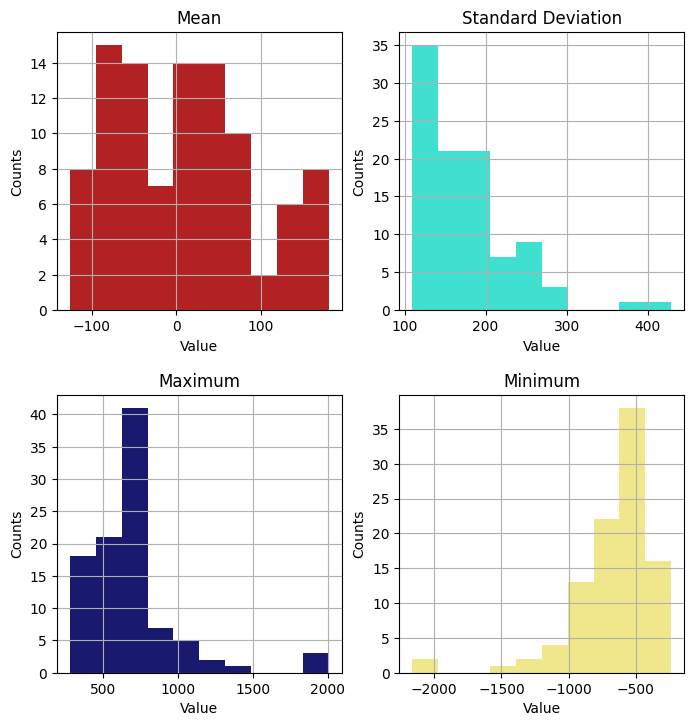

In [66]:
#put features into labeled dataframe
stats_df = pd.DataFrame(features, columns=['Mean', 'Std', 'Max', 'Min'])

#plot histogram for each stat
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(7,7)
plt.tight_layout(h_pad=4)

axs[0][0].hist(stats_df['Mean'], color='firebrick')
axs[0][0].set_title('Mean')
axs[0][0].set_xlabel('Value')
axs[0][0].set_ylabel('Counts')
axs[0][0].grid()

axs[0][1].hist(stats_df['Std'], color='turquoise')
axs[0][1].set_title('Standard Deviation')
axs[0][1].set_xlabel('Value')
axs[0][1].set_ylabel('Counts')
axs[0][1].grid()

axs[1][0].hist(stats_df['Max'], color='midnightblue')
axs[1][0].set_title('Maximum')
axs[1][0].set_xlabel('Value')
axs[1][0].set_ylabel('Counts')
axs[1][0].grid()

axs[1][1].hist(stats_df['Min'], color='khaki')
axs[1][1].set_title('Minimum')
axs[1][1].set_xlabel('Value')
axs[1][1].set_ylabel('Counts')
axs[1][1].grid();

## Compute overall spectra and spectrogram of data

/var/folders/jz/1_5zh2bj42bb_8hlyhd9lfxw0000gn/T/ipykernel_38430/3103230396.py:18: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(np.min(f), np.max(f))


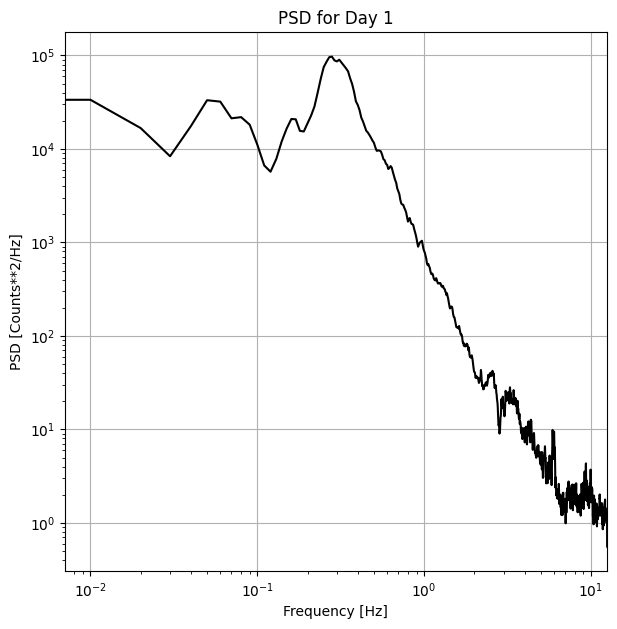

In [85]:
from scipy import signal

#compute power spectral density using Welch's Method
fs = 25 #sampling rate in hz
window = 10*10 #second window to compute ffts over, at least 10x the period of the lowest freq you care about

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(east_component_data))

#welch returns frequency and power given a signal and sampling rate
f, Pxx_den = signal.welch(east_component_data*taper, fs, nperseg=window*fs)

plt.figure(figsize=(7,7))
plt.loglog(f, Pxx_den, color='k')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [Counts**2/Hz]')
plt.title('PSD for Day '+file_name.split('_')[0])
plt.xlim(np.min(f), np.max(f))
plt.grid();

/var/folders/jz/1_5zh2bj42bb_8hlyhd9lfxw0000gn/T/ipykernel_38430/1363491574.py:12: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', cmap='magma')


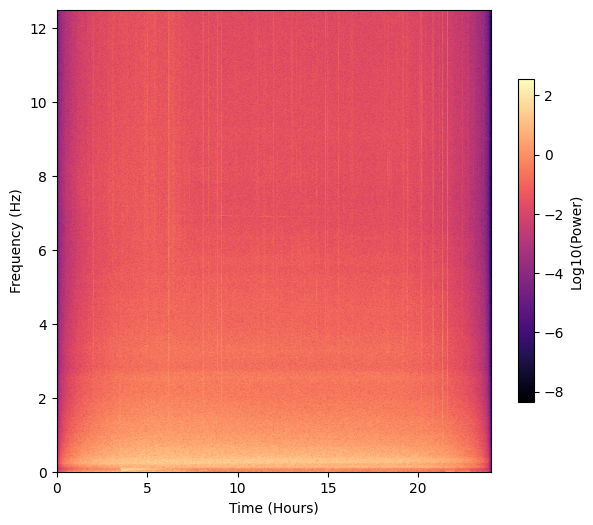

In [98]:
#plot spectrogram
fs = 25
window = 10*10

#generate a Tukey window to taper the data with
taper = signal.windows.tukey(len(east_component_data))

#compute the spectrogram
f, t, Zxx = signal.stft(taper*east_component_data, fs=fs, nperseg=window*fs, noverlap=200)

plt.figure(figsize=(7,6))
plt.pcolormesh(t/3600, f, np.log10(np.abs(Zxx)), shading='gouraud', cmap='magma')
plt.colorbar(label='Log10(Power)', shrink=0.7)
plt.xlabel('Time (Hours)')
plt.ylabel('Frequency (Hz)');

## Conclusion <br>

This introductory analysis shows that our data is more or less evenly distributed around 0, as expected, and has a large standard deviation, owing to its signal fluctuating wildly between extreme values. The frequency analysis shows that much of the signal's energy is concentrated below 1 Hz, and for this day of data, is relatively stable. <br>

Correlation analysis is included in the Dimensionality Reduction notebook rather than here, as it feeds naturally into feature selection.



### Task ###
Perform a basic exploration of the cleaned data to understand its structure and key characteristics.

### Requirements ###

This notebook will include:
- Basic summary statistics of the dataset (mean, variance, min, max, etc.).
- Visualization of feature distributions (histograms, box plots, etc.).
- Correlation analysis between different features and target variables (correlation matrix, heatmaps).
- Brief discussion on any patterns or insights observed during the analysis.
